In [ ]:
# =========================
# ETAPE 1 — Chargement NAB
# =========================
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler

category = "realKnownCause"
fname    = "ambient_temperature_system_failure.csv"

raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

# Détecter les colonnes temps / valeur
time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:
    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

# 3) Créer les labels point-par-point (0/1)
ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)
for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)
scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])


n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realKnownCause/ambient_temperature_system_failure.csv
Période: 2013-07-04 00:00:00 -> 2014-05-28 15:00:00 | n=7267
Fenêtres NAB: 2 | Points anormaux (NAB): 726


,timestamp,value,label,x
0,2013-07-04 00:00:00,69.880835,0,-0.336285
1,2013-07-04 01:00:00,71.220227,0,0.006880
2,2013-07-04 02:00:00,70.877805,0,-0.080852
3,2013-07-04 03:00:00,68.959400,0,-0.572366
4,2013-07-04 04:00:00,69.283551,0,-0.489316


In [ ]:
# =========================
# ETAPE 2 — Fenêtrage + masques
# =========================
import numpy as np
import pandas as pd

SEQ_LEN = 30

def to_windows(series: pd.Series, seq_len: int):
    X = []
    for i in range(len(series) - seq_len):
        X.append(series.iloc[i:i+seq_len].values.reshape(seq_len, 1))
    return np.array(X)

# 1) Fenêtres sur la série standardisée df["x"]
X_all = to_windows(df["x"], SEQ_LEN)

# 2) Date associée à chaque fenêtre = date du dernier point de la fenêtre
dates_all = df[TIME_COL].iloc[SEQ_LEN:].reset_index(drop=True)

# 3) Marquer si une fenêtre touche une anomalie
labels_points = df["label"].astype(bool).to_numpy()
win_is_anom = np.array([
    labels_points[i:i+SEQ_LEN].any()
    for i in range(len(labels_points) - SEQ_LEN)
], dtype=bool)

# 4) Masques pour l'entraînement
idx_norm = ~win_is_anom
X_train  = X_all[idx_norm]
n_all, n_norm, n_anom = len(X_all), int(idx_norm.sum()), int((~idx_norm).sum())

print(f"Fenêtres totales : {n_all}")
print(f"   ↳ 100% normales (train) : {n_norm}")
print(f"   ↳ touchent une anomalie : {n_anom}")

print("\nVérifs de shapes :")
print("X_all :", X_all.shape, "| X_train :", X_train.shape, "| dates_all :", dates_all.shape)

Fenêtres totales : 7237
   ↳ 100% normales (train) : 6453
   ↳ touchent une anomalie : 784

Vérifs de shapes :
X_all : (7237, 30, 1) | X_train : (6453, 30, 1) | dates_all : (7237,)


In [ ]:
# =========================
# ETAPE 3 LSTM + Autoencodeur
# =========================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras import regularizers

latent_dim = 64
reg_l2 = 1e-5
drop = 0.3

# --- Encodeur ---
inputs = Input(shape=(SEQ_LEN, 1))
encoded = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(inputs)
encoded = Dropout(drop)(encoded)
encoded = LSTM(latent_dim, return_sequences=False, kernel_regularizer=regularizers.l2(reg_l2))(encoded)

# --- Bottleneck ---
bottleneck = RepeatVector(SEQ_LEN)(encoded)

# --- Décodeur ---
decoded = LSTM(latent_dim, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(bottleneck)
decoded = Dropout(drop)(decoded)
decoded = LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(reg_l2))(decoded)
outputs = TimeDistributed(Dense(1))(decoded)

# --- Modèle complet ---
model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mae")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement sur 5808 fenêtres, validation sur 645.
Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - loss: 0.4070 - val_loss: 0.4996
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.2691 - val_loss: 0.3775
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 0.2034 - val_loss: 0.2880
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - loss: 0.1742 - val_loss: 0.2908
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 0.1612 - val_loss: 0.2448
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - loss: 0.1576 - val_loss: 0.2249
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 0.1502 - val_loss: 0.2150
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - loss: 0.1475 - val_loss: 0.2243
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - loss: 0.1458 - val_loss: 0.2143
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.1441 - val_loss: 0.2204
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.1414 - val_lo

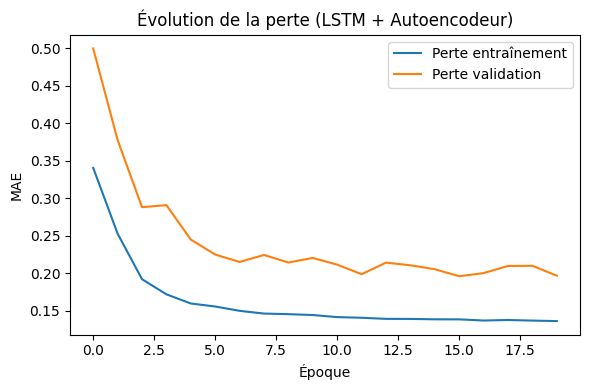

In [ ]:
# =========================
# ETAPE 4 — Entraînement
# =========================
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping :arrête si la perte de validation ne s’améliore plus
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# On garde les 10 % dernières fenêtres normales pour validation temporelle
val_split = 0.1
n_val = int(len(X_train) * val_split)
X_train_sub = X_train[:-n_val]
X_val_sub   = X_train[-n_val:]

print(f"Entraînement sur {len(X_train_sub)} fenêtres, validation sur {len(X_val_sub)}.")

history = model.fit(
    X_train_sub, X_train_sub,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_sub, X_val_sub),
    callbacks=[es],
    verbose=1
)

# --- Courbe de perte ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Perte entraînement")
plt.plot(history.history["val_loss"], label="Perte validation")
plt.xlabel("Époque")
plt.ylabel("MAE")
plt.legend()
plt.title("Évolution de la perte (LSTM + Autoencodeur)")
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# Reconstruction
# =========================
import numpy as np
import pandas as pd

# 1) Prédire toutes les fenêtres et recoller
pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask_valid = recon_count > 0
recon[mask_valid] = recon_sum[mask_valid] / recon_count[mask_valid]

# 2) Remettre la reconstruction à l’échelle d’origine
try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except Exception:
    recon_value = recon
    orig_value  = df["x"].to_numpy()

# 3) Erreur pointwise + lissage
df["recon"]      = recon_value
df["abs_err"]    = np.abs(orig_value - recon_value)
df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

# Lissage
WIN = 7
df["err_smooth"] = (
    df["abs_err"]
    .rolling(WIN, center=True, min_periods=1).median()
    .rolling(WIN, center=True, min_periods=1).mean()
)

valid_pts = df["err_smooth"].notna().sum()
print(f"Reconstruction OK. Points valides pour l'erreur lissée : {valid_pts}/{len(df)}")
display(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head(10))

Reconstruction OK. Points valides pour l'erreur lissée : 7244/7267


,timestamp,value,recon,abs_err,err_smooth
0,2013-07-04 00:00:00,69.880835,70.600160,NaN,NaN
1,2013-07-04 01:00:00,71.220227,70.441501,NaN,NaN
2,2013-07-04 02:00:00,70.877805,70.229564,NaN,NaN
3,2013-07-04 03:00:00,68.959400,69.999266,NaN,NaN
4,2013-07-04 04:00:00,69.283551,69.812885,NaN,NaN
5,2013-07-04 05:00:00,70.060966,69.648763,NaN,NaN
6,2013-07-04 06:00:00,69.279765,69.478336,NaN,NaN
7,2013-07-04 07:00:00,69.369608,69.344292,NaN,NaN
8,2013-07-04 08:00:00,69.166714,69.271242,NaN,NaN
9,2013-07-04 09:00:00,68.986083,69.286904,NaN,NaN


In [ ]:
# =========================
# Seuils
# =========================
import numpy as np
import pandas as pd

# 1) Seuils calculés sur les points normaux uniquement
valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask
norm_err = df.loc[normal_mask_points, "err_smooth"].values

Q_HIGH, Q_LOW = 0.99, 0.95
seuil_haut = np.quantile(norm_err, Q_HIGH)
seuil_bas  = np.quantile(norm_err, Q_LOW)
print(f"Seuils (calculés sur le normal) -> haut={seuil_haut:.4f} (Q{int(Q_HIGH*100)}), bas={seuil_bas:.4f} (Q{int(Q_LOW*100)})")

# 2) Hystérèse avec PERSISTANCE
L_up, L_down = 3, 5

err = df["err_smooth"].to_numpy()
flags = np.zeros(len(err), dtype=bool)
state = False
up_cnt = down_cnt = 0

for i, e in enumerate(err):
    if not np.isfinite(e):
        flags[i] = state
        continue
    if not state:
        if e > seuil_haut:
            up_cnt += 1
            if up_cnt >= L_up:
                state = True
                down_cnt = 0
        else:
            up_cnt = 0
    else:
        if e < seuil_bas:
            down_cnt += 1
            if down_cnt >= L_down:
                state = False
                up_cnt = 0
        else:
            down_cnt = 0
    flags[i] = state

# 3) Comptes au niveau POINT
y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))
n_true = int(np.sum(y_true))
n_pred = int(np.sum(y_pred))
n_total = int(np.sum(valid_mask))

precision = TP / (TP + FP) if (TP+FP) else 0.0
recall    = TP / (TP + FN) if (TP+FN) else 0.0
f1        = 2*precision*recall / (precision+recall) if (precision+recall) else 0.0

print("\n📊 Comptes point-par-point :")
print(f"- Points valides                : {n_total}")
print(f"- VRAIS points anormaux (NAB)   : {n_true}")
print(f"- Points détectés par le LSTM   : {n_pred}")
print(f"   ↳ Vrais positifs (TP)        : {TP}")
print(f"   ↳ Faux positifs (FP)         : {FP}")
print(f"   ↳ Faux négatifs (FN)         : {FN}")
print(f"   ↳ Vrais négatifs (TN)        : {TN}")
print(f"\nMetrics : Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

# 4) Extraire les DATES des points détectés (aperçu + export CSV)
detected_points = df.loc[y_pred, [TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].rename(
    columns={TIME_COL: "timestamp", VALUE_COL: "value"}
)
print("\n🕒 Aperçu des points détectés (les 15 premiers) :")
display(detected_points.head(15))

out_path = "detected_points.csv"
detected_points.to_csv(out_path, index=False)
print(f"\n💾 Exporté : {out_path}  (timestamps + valeurs + erreurs)")

Seuils (calculés sur le normal) -> haut=1.1960 (Q99), bas=0.7053 (Q95)

📊 Comptes point-par-point :
- Points valides                : 7244
- VRAIS points anormaux (NAB)   : 726
- Points détectés par le LSTM   : 228
   ↳ Vrais positifs (TP)        : 123
   ↳ Faux positifs (FP)         : 105
   ↳ Faux négatifs (FN)         : 603
   ↳ Vrais négatifs (TN)        : 6436

Metrics : Precision=0.539 | Recall=0.169 | F1=0.258

🕒 Aperçu des points détectés (les 15 premiers) :


,timestamp,value,recon,abs_err,err_smooth
3696,2013-12-21 19:00:00,79.896875,79.177944,0.718931,1.863323
3697,2013-12-21 20:00:00,82.289240,79.554434,2.734806,2.188658
3698,2013-12-21 21:00:00,82.989869,79.849324,3.140545,2.424026
3699,2013-12-21 22:00:00,83.247886,80.049293,3.198594,2.625909
3700,2013-12-21 23:00:00,82.519659,80.156111,2.363548,2.796210
3701,2013-12-22 00:00:00,82.736802,80.177933,2.558869,2.881681
3702,2013-12-22 01:00:00,83.780995,80.125687,3.655308,2.939249
3703,2013-12-22 02:00:00,83.008634,80.012356,2.996278,2.967884
3704,2013-12-22 03:00:00,82.815627,79.853782,2.961845,2.959167
3705,2013-12-22 04:00:00,81.774744,79.669381,2.105363,2.932543



💾 Exporté : detected_points.csv  (timestamps + valeurs + erreurs)


In [ ]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

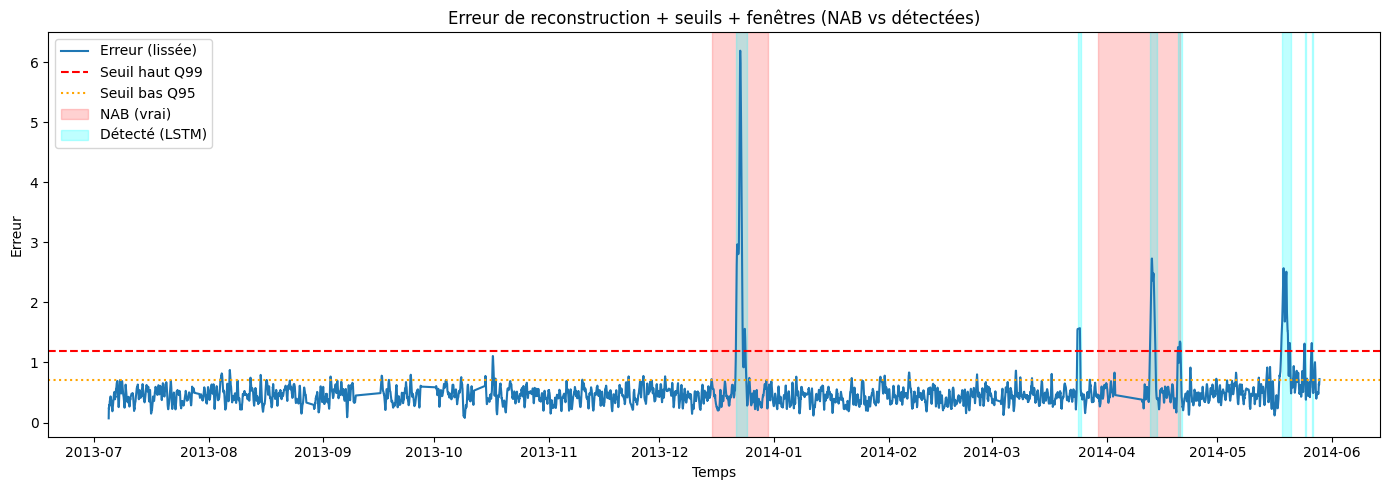

Fenêtres NAB : [(Timestamp('2013-12-15 07:00:00'), Timestamp('2013-12-30 09:00:00')), (Timestamp('2014-03-29 15:00:00'), Timestamp('2014-04-20 22:00:00'))]
Fenêtres détectées : [(Timestamp('2013-12-21 19:00:00'), Timestamp('2013-12-24 17:00:00')), (Timestamp('2014-03-24 04:00:00'), Timestamp('2014-03-25 04:00:00')), (Timestamp('2014-04-12 21:00:00'), Timestamp('2014-04-14 13:00:00')), (Timestamp('2014-04-20 10:00:00'), Timestamp('2014-04-21 10:00:00')), (Timestamp('2014-05-18 09:00:00'), Timestamp('2014-05-21 01:00:00'))] ... (total 7 )


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reconstruit les intervalles à partir des flags booléens
def flags_to_intervals(flags, dates):
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(flags, df[TIME_COL])
true_ints = load_anomaly_windows_for("realKnownCause/ambient_temperature_system_failure.csv")

plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur (lissée)")
plt.axhline(seuil_haut, color="r", ls="--", label=f"Seuil haut Q{int(Q_HIGH*100)}")
plt.axhline(seuil_bas,  color="orange", ls=":", label=f"Seuil bas Q{int(Q_LOW*100)}")

lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True

lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (LSTM)")
    lab_done = True

plt.title("Erreur de reconstruction + seuils + fenêtres (NAB vs détectées)")
plt.xlabel("Temps"); plt.ylabel("Erreur")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Fenêtres NAB :", true_ints)
print("Fenêtres détectées :", detected_ints[:5], "... (total", len(detected_ints), ")")

In [ ]:
# =========================
# Seuils
# =========================
import numpy as np
import pandas as pd

# 1) Seuils calculés sur les points normaux uniquement
valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask
norm_err = df.loc[normal_mask_points, "err_smooth"].values

Q_HIGH, Q_LOW = 0.996, 0.07299999
seuil_haut = np.quantile(norm_err, Q_HIGH)
seuil_bas  = np.quantile(norm_err, Q_LOW)
print(f"Seuils (calculés sur le normal) -> haut={seuil_haut:.4f} (Q{int(Q_HIGH*100)}), bas={seuil_bas:.4f} (Q{int(Q_LOW*100)})")

# 2) Hystérèse avec PERSISTANCE
L_up, L_down = 3, 5
err = df["err_smooth"].to_numpy()
flags = np.zeros(len(err), dtype=bool)
state = False
up_cnt = down_cnt = 0

for i, e in enumerate(err):
    if not np.isfinite(e):
        flags[i] = state
        continue
    if not state:
        if e > seuil_haut:
            up_cnt += 1
            if up_cnt >= L_up:
                state = True
                down_cnt = 0
        else:
            up_cnt = 0
    else:
        if e < seuil_bas:
            down_cnt += 1
            if down_cnt >= L_down:
                state = False
                up_cnt = 0
        else:
            down_cnt = 0
    flags[i] = state

y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))
n_true = int(np.sum(y_true))
n_pred = int(np.sum(y_pred))
n_total = int(np.sum(valid_mask))

precision = TP / (TP + FP) if (TP+FP) else 0.0
recall    = TP / (TP + FN) if (TP+FN) else 0.0
f1        = 2*precision*recall / (precision+recall) if (precision+recall) else 0.0

print("\n📊 Comptes point-par-point :")
print(f"- Points valides                : {n_total}")
print(f"- VRAIS points anormaux (NAB)   : {n_true}")
print(f"- Points détectés par le LSTM   : {n_pred}")
print(f"   ↳ Vrais positifs (TP)        : {TP}")
print(f"   ↳ Faux positifs (FP)         : {FP}")
print(f"   ↳ Faux négatifs (FN)         : {FN}")
print(f"   ↳ Vrais négatifs (TN)        : {TN}")
print(f"\nMetrics : Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

# 4) Extraire les DATES des points détectés (aperçu + export CSV)
detected_points = df.loc[y_pred, [TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].rename(
    columns={TIME_COL: "timestamp", VALUE_COL: "value"}
)
print("\n🕒 Aperçu des points détectés (les 15 premiers) :")
display(detected_points.head(15))

out_path = "detected_points.csv"
detected_points.to_csv(out_path, index=False)
print(f"\n💾 Exporté : {out_path}  (timestamps + valeurs + erreurs)")

Seuils (calculés sur le normal) -> haut=1.7600 (Q99), bas=0.2700 (Q7)

📊 Comptes point-par-point :
- Points valides                : 7244
- VRAIS points anormaux (NAB)   : 726
- Points détectés par le LSTM   : 434
   ↳ Vrais positifs (TP)        : 194
   ↳ Faux positifs (FP)         : 240
   ↳ Faux négatifs (FN)         : 532
   ↳ Vrais négatifs (TN)        : 6301

Metrics : Precision=0.447 | Recall=0.267 | F1=0.334

🕒 Aperçu des points détectés (les 15 premiers) :


,timestamp,value,recon,abs_err,err_smooth
3698,2013-12-21 21:00:00,82.989869,79.849324,3.140545,2.424026
3699,2013-12-21 22:00:00,83.247886,80.049293,3.198594,2.625909
3700,2013-12-21 23:00:00,82.519659,80.156111,2.363548,2.796210
3701,2013-12-22 00:00:00,82.736802,80.177933,2.558869,2.881681
3702,2013-12-22 01:00:00,83.780995,80.125687,3.655308,2.939249
3703,2013-12-22 02:00:00,83.008634,80.012356,2.996278,2.967884
3704,2013-12-22 03:00:00,82.815627,79.853782,2.961845,2.959167
3705,2013-12-22 04:00:00,81.774744,79.669381,2.105363,2.932543
3706,2013-12-22 05:00:00,82.454278,79.477559,2.976719,2.928745
3707,2013-12-22 06:00:00,82.091901,79.281992,2.809909,2.907040



💾 Exporté : detected_points.csv  (timestamps + valeurs + erreurs)


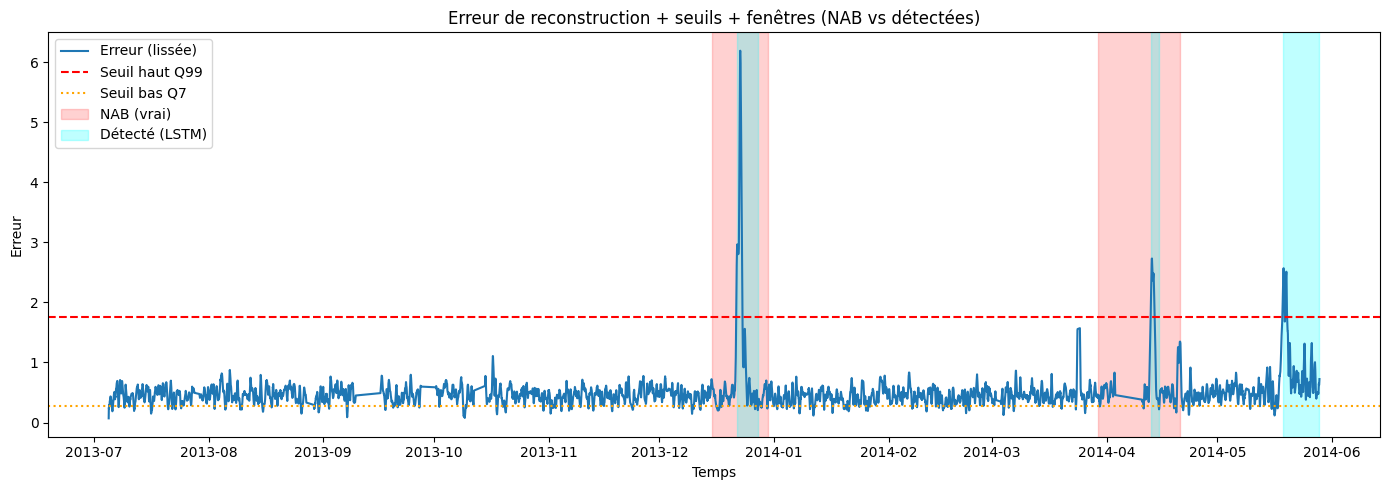

Fenêtres NAB : [(Timestamp('2013-12-15 07:00:00'), Timestamp('2013-12-30 09:00:00')), (Timestamp('2014-03-29 15:00:00'), Timestamp('2014-04-20 22:00:00'))]
Fenêtres détectées : [(Timestamp('2013-12-21 21:00:00'), Timestamp('2013-12-27 17:00:00')), (Timestamp('2014-04-13 01:00:00'), Timestamp('2014-04-15 07:00:00')), (Timestamp('2014-05-18 16:00:00'), Timestamp('2014-05-28 15:00:00'))] ... (total 3 )


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reconstruit les intervalles à partir des flags booléens
def flags_to_intervals(flags, dates):
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(flags, df[TIME_COL])
true_ints = load_anomaly_windows_for("realKnownCause/ambient_temperature_system_failure.csv")

plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur (lissée)")
plt.axhline(seuil_haut, color="r", ls="--", label=f"Seuil haut Q{int(Q_HIGH*100)}")
plt.axhline(seuil_bas,  color="orange", ls=":", label=f"Seuil bas Q{int(Q_LOW*100)}")

lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True

lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (LSTM)")
    lab_done = True

plt.title("Erreur de reconstruction + seuils + fenêtres (NAB vs détectées)")
plt.xlabel("Temps"); plt.ylabel("Erreur")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Fenêtres NAB :", true_ints)
print("Fenêtres détectées :", detected_ints[:5], "... (total", len(detected_ints), ")")

In [ ]:
# =========================
#Seuils
# =========================
import numpy as np
import pandas as pd

# 1) Seuils calculés sur les points normaux uniquement
valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask
norm_err = df.loc[normal_mask_points, "err_smooth"].values

Q_HIGH, Q_LOW = 0.9999999999999999999999999999 , 0.10
seuil_haut = np.quantile(norm_err, Q_HIGH)
seuil_bas  = np.quantile(norm_err, Q_LOW)
print(f"Seuils (calculés sur le normal) -> haut={seuil_haut:.4f} (Q{int(Q_HIGH*100)}), bas={seuil_bas:.4f} (Q{int(Q_LOW*100)})")

L_up, L_down = 5, 7

err   = df["err_smooth"].to_numpy()
dates = df[TIME_COL].to_numpy()

state = False
up_cnt = 0
down_cnt = 0
start_idx = None
saw_high  = False

intervals_idx = []

for i, e in enumerate(err):
    if not np.isfinite(e):
        continue

    if not state:
        if e > seuil_bas:
            up_cnt += 1
            if up_cnt >= L_up:
                state = True
                start_idx = i - L_up + 1
                saw_high = (e > seuil_haut)
                down_cnt = 0
        else:
            up_cnt = 0

    else:
        if e > seuil_haut:
            saw_high = True

        if e < seuil_bas:
            down_cnt += 1
            if down_cnt >= L_down:

                if saw_high and start_idx is not None:
                    intervals_idx.append((start_idx, i))

                state = False
                up_cnt = 0
                down_cnt = 0
                start_idx = None
                saw_high = False
        else:
            down_cnt = 0

if state and (start_idx is not None) and saw_high:
    intervals_idx.append((start_idx, len(err)-1))

flags = np.zeros(len(err), dtype=bool)
for s, e in intervals_idx:
    flags[s:e+1] = True

# 3) Comptes au niveau POINT
y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))
n_true = int(np.sum(y_true))
n_pred = int(np.sum(y_pred))
n_total = int(np.sum(valid_mask))

precision = TP / (TP + FP) if (TP+FP) else 0.0
recall    = TP / (TP + FN) if (TP+FN) else 0.0
f1        = 2*precision*recall / (precision+recall) if (precision+recall) else 0.0

print("\n📊 Comptes point-par-point :")
print(f"- Points valides                : {n_total}")
print(f"- VRAIS points anormaux (NAB)   : {n_true}")
print(f"- Points détectés par le LSTM   : {n_pred}")
print(f"   ↳ Vrais positifs (TP)        : {TP}")
print(f"   ↳ Faux positifs (FP)         : {FP}")
print(f"   ↳ Faux négatifs (FN)         : {FN}")
print(f"   ↳ Vrais négatifs (TN)        : {TN}")
print(f"\nMetrics : Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

# 4) Extraire les DATES des points détectés (aperçu + export CSV)
y_pred_points = flags & valid_mask
detected_points = df.loc[y_pred_points, [TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].rename(
    columns={TIME_COL: "timestamp", VALUE_COL: "value"}
)
print("\n🕒 Aperçu des points détectés (les 15 premiers) :")
display(detected_points.head(15))

out_path = "detected_points.csv"
detected_points.to_csv(out_path, index=False)
print(f"\n💾 Exporté : {out_path}  (timestamps + valeurs + erreurs)")


Seuils (calculés sur le normal) -> haut=2.5700 (Q100), bas=0.2900 (Q10)

📊 Comptes point-par-point :
- Points valides                : 7244
- VRAIS points anormaux (NAB)   : 726
- Points détectés par le LSTM   : 734
   ↳ Vrais positifs (TP)        : 637
   ↳ Faux positifs (FP)         : 97
   ↳ Faux négatifs (FN)         : 89
   ↳ Vrais négatifs (TN)        : 6444

Metrics : Precision=0.868 | Recall=0.877 | F1=0.873

🕒 Aperçu des points détectés (les 15 premiers) :


,timestamp,value,recon,abs_err,err_smooth
3588,2013-12-17 07:00:00,76.904492,76.287416,0.617075,0.302741
3589,2013-12-17 08:00:00,76.176635,76.150019,0.026616,0.347430
3590,2013-12-17 09:00:00,75.637747,76.004536,0.366789,0.392424
3591,2013-12-17 10:00:00,74.761114,75.865420,1.104307,0.476345
3592,2013-12-17 11:00:00,75.904211,75.747177,0.157034,0.499470
3593,2013-12-17 12:00:00,76.507919,75.649200,0.858719,0.544464
3594,2013-12-17 13:00:00,75.035695,75.564357,0.528662,0.523394
3595,2013-12-17 14:00:00,76.447886,75.508480,0.939405,0.479199
3596,2013-12-17 15:00:00,75.693496,75.474197,0.219299,0.435004
3597,2013-12-17 16:00:00,74.673691,75.474839,0.801147,0.396764



💾 Exporté : detected_points.csv  (timestamps + valeurs + erreurs)


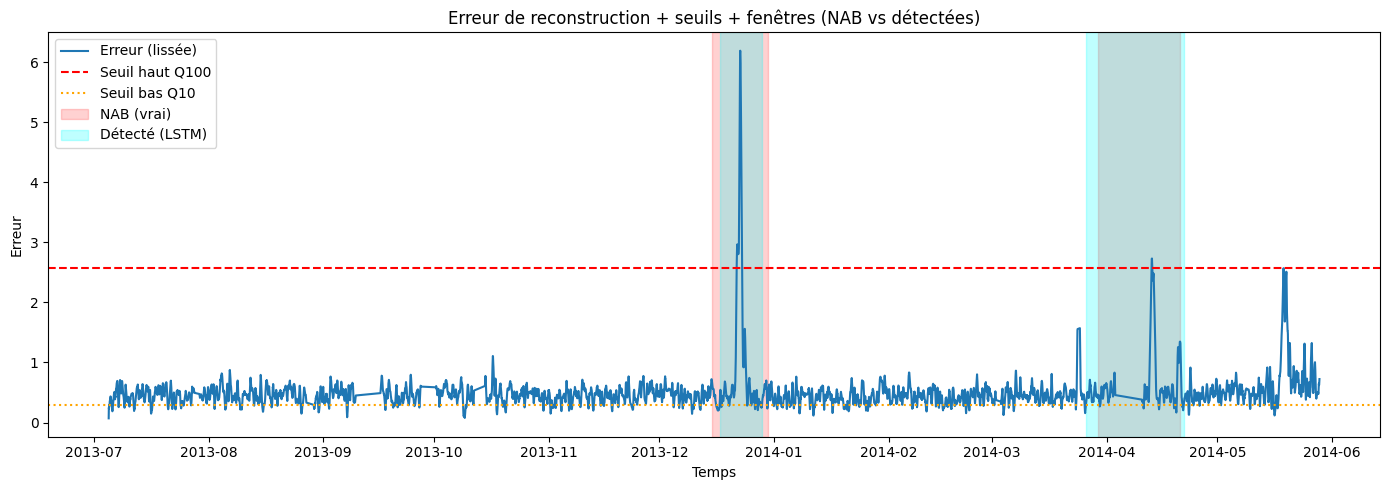

Fenêtres NAB : [(Timestamp('2013-12-15 07:00:00'), Timestamp('2013-12-30 09:00:00')), (Timestamp('2014-03-29 15:00:00'), Timestamp('2014-04-20 22:00:00'))]
Fenêtres détectées : [(Timestamp('2013-12-17 07:00:00'), Timestamp('2013-12-28 17:00:00')), (Timestamp('2014-03-26 11:00:00'), Timestamp('2014-04-21 20:00:00'))] ... (total 2 )


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reconstruit les intervalles à partir des flags booléens
def flags_to_intervals(flags, dates):
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(flags, df[TIME_COL])
true_ints = load_anomaly_windows_for("realKnownCause/ambient_temperature_system_failure.csv")

plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur (lissée)")
plt.axhline(seuil_haut, color="r", ls="--", label=f"Seuil haut Q{int(Q_HIGH*100)}")
plt.axhline(seuil_bas,  color="orange", ls=":", label=f"Seuil bas Q{int(Q_LOW*100)}")

lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True

lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (LSTM)")
    lab_done = True

plt.title("Erreur de reconstruction + seuils + fenêtres (NAB vs détectées)")
plt.xlabel("Temps"); plt.ylabel("Erreur")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Fenêtres NAB :", true_ints)
print("Fenêtres détectées :", detected_ints[:5], "... (total", len(detected_ints), ")")

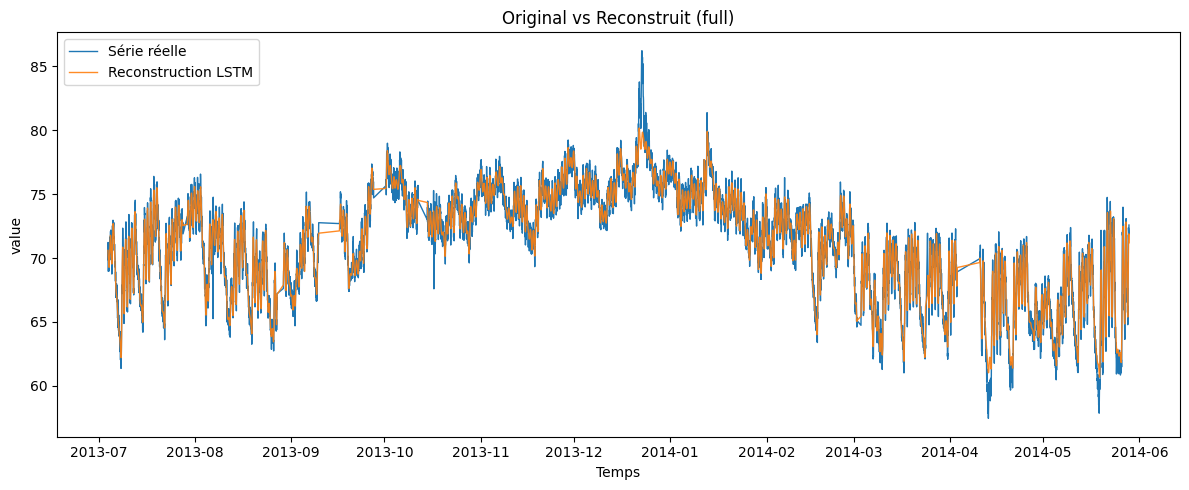

In [ ]:
# ===============================
# Reconstruction LSTM vs série
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Prédire toutes les fenêtres
pred_all = model.predict(X_all, verbose=0)
pred_all = pred_all.squeeze(-1)

# 2) Recoller les fenêtres
n = len(df)
recon_sum   = np.zeros(n)
recon_count = np.zeros(n)

for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

valid_mask = recon_count > 0
recon = np.zeros(n)
recon[valid_mask] = recon_sum[valid_mask] / recon_count[valid_mask]

# 3) Ramener à l’échelle d’origine
try:

    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    original_value = df[VALUE_COL].to_numpy()
except Exception:

    recon_value = recon
    original_value = df.get("x", df[VALUE_COL]).to_numpy()

# 4) Tracer
def plot_reconstruction(start=None, end=None, show_true=True, title_suffix="(full)"):
    ts = df[TIME_COL]
    mask = np.ones(len(df), dtype=bool)
    if start is not None:
        mask &= (ts >= pd.to_datetime(start))
    if end is not None:
        mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], original_value[mask], lw=1, label="Série réelle")
    plt.plot(ts[mask], recon_value[mask], lw=1, alpha=0.9, label="Reconstruction LSTM")

    # bandes anomalies vraies
    if show_true and 'true_intervals' in globals() and len(true_intervals):
        once = True
        for s,e in true_intervals:
            if (s <= ts[mask].iloc[-1]) and (e >= ts[mask].iloc[0]):
                plt.axvspan(s, e, alpha=0.18, color="red",
                            label="Anomalie vraie (NAB)" if once else None)
                once = False

    plt.title(f"Original vs Reconstruit {title_suffix}")
    plt.xlabel("Temps"); plt.ylabel(VALUE_COL)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot_reconstruction()

In [ ]:
import pandas as pd, numpy as np, requests
from sklearn.preprocessing import StandardScaler

category = "realKnownCause"
fname    = "machine_temperature_system_failure.csv"

# 1) Charger la série depuis GitHub
raw_csv = f"https://raw.githubusercontent.com/numenta/NAB/master/data/{category}/{fname}"
df = pd.read_csv(raw_csv)

# Détecter les colonnes temps / valeur
time_candidates  = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
if not time_candidates:
    raise ValueError("Impossible de trouver la colonne temps (contient 'time' ou 'date').")
TIME_COL = time_candidates[0]
value_candidates = [c for c in df.columns if c != TIME_COL and df[c].dtype != "object"]
if not value_candidates:

    for c in df.columns:
        if c != TIME_COL:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            if df[c].notna().any():
                value_candidates = [c]; break
if not value_candidates:
    raise ValueError("Impossible de trouver la colonne valeur.")
VALUE_COL = value_candidates[0]

# Nettoyage + tri temporel
df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df[[TIME_COL, VALUE_COL]].dropna().sort_values(TIME_COL).reset_index(drop=True)

# 2) Charger les fenêtres d'anomalies
labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
windows = requests.get(labels_url).json()
key = f"{category}/{fname}"
win_list = windows.get(key, [])

# 3) Créer les labels point-par-point (0/1)
ts = df[TIME_COL].to_numpy()
labels_points = np.zeros(len(df), dtype=bool)

for w in win_list:
    if isinstance(w, dict):
        s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
    elif isinstance(w, (list, tuple)) and len(w) >= 2:
        s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
    else:
        continue
    labels_points |= (ts >= s) & (ts <= e)

df["label"] = labels_points.astype(int)

# 4) Standardiser uniquement sur le normal
scaler = StandardScaler().fit(df.loc[df["label"]==0, [VALUE_COL]])
df["x"] = scaler.transform(df[[VALUE_COL]])

n_total = len(df)
n_anom  = int(df["label"].sum())
print(f"Série chargée: {key}")
print(f"Période: {df[TIME_COL].min()} -> {df[TIME_COL].max()} | n={n_total}")
print(f"Fenêtres NAB: {len(win_list)} | Points anormaux (NAB): {n_anom}")
display(df.head())

Série chargée: realKnownCause/machine_temperature_system_failure.csv
Période: 2013-12-02 21:15:00 -> 2014-02-19 15:25:00 | n=22695
Fenêtres NAB: 4 | Points anormaux (NAB): 2268


,timestamp,value,label,x
0,2013-12-02 21:15:00,73.967322,0,-1.470620
1,2013-12-02 21:20:00,74.935882,0,-1.371648
2,2013-12-02 21:25:00,76.124162,0,-1.250224
3,2013-12-02 21:30:00,78.140707,0,-1.044165
4,2013-12-02 21:35:00,79.329836,0,-0.922655


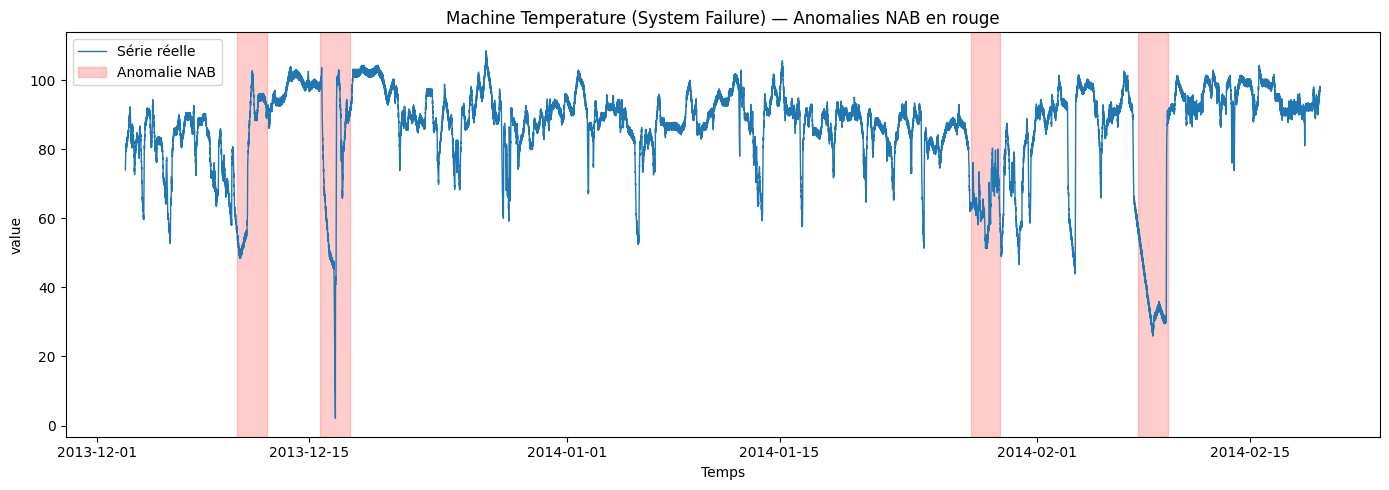

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Charger les fenêtres d'anomalies NAB pour cette série
true_ints = load_anomaly_windows_for(
    "realKnownCause/machine_temperature_system_failure.csv"
)

# 2) Tracer la série
plt.figure(figsize=(14, 5))
ts = df[TIME_COL]
vals = df[VALUE_COL]

plt.plot(ts, vals, lw=1, label="Série réelle")

first = True
for start, end in true_ints:
    plt.axvspan(start, end,
                color="red", alpha=0.2,
                label="Anomalie NAB" if first else None)
    first = False

plt.title("Machine Temperature (System Failure) — Anomalies NAB en rouge")
plt.xlabel("Temps")
plt.ylabel(VALUE_COL)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# 1) Standardiser la colonne valeur de la nouvelle série
df_new["x"] = scaler.transform(df_new[[VALUE_COL_NEW]])

# 2) Créer les fenêtres glissantes avec la même SEQ_LEN
X_new_all = to_windows(df_new["x"], SEQ_LEN)

print("len(df_new) :", len(df_new))
print("X_new_all shape :", X_new_all.shape)

len(df_new) : 22695
X_new_all shape : (22665, 30, 1)


In [ ]:
# =========================
# G3 — Reconstruction
# =========================
import numpy as np

# 1) Prédire toutes les fenêtres
pred_new = model.predict(X_new_all, verbose=0).squeeze(-1)

n_new = len(df_new)
recon_sum   = np.zeros(n_new)
recon_count = np.zeros(n_new)

# recoller les fenêtres
for w in range(pred_new.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_new[w]
    recon_count[start:end] += 1

valid_mask_new = recon_count > 0
recon_new = np.full(n_new, np.nan)
recon_new[valid_mask_new] = recon_sum[valid_mask_new] / recon_count[valid_mask_new]

# 2) Revenir à l’échelle d’origine
try:
    recon_value_new = scaler.inverse_transform(recon_new.reshape(-1,1)).ravel()
    original_value_new = df_new[VALUE_COL_NEW].to_numpy()
except Exception:
    recon_value_new = recon_new
    original_value_new = df_new[VALUE_COL_NEW].to_numpy()

# 3) Erreur point-par-point + lissage
abs_err_new = np.abs(original_value_new - recon_value_new)
df_new["recon"]      = recon_value_new
df_new["abs_err"]    = abs_err_new

WIN = 50
df_new["err_smooth"] = (
    df_new["abs_err"]
    .rolling(WIN, center=True, min_periods=1).median()
    .rolling(WIN, center=True, min_periods=1).mean()
)

print("Reconstruction terminée sur machine_temperature.")
print(df_new[[TIME_COL_NEW, VALUE_COL_NEW, "recon", "abs_err", "err_smooth"]].head())

Reconstruction terminée sur machine_temperature.
            timestamp      value      recon   abs_err  err_smooth
0 2013-12-02 21:15:00  73.967322  77.944185  3.976863    0.493519
1 2013-12-02 21:20:00  74.935882  77.954499  3.018617    0.493618
2 2013-12-02 21:25:00  76.124162  78.395657  2.271495    0.493313
3 2013-12-02 21:30:00  78.140707  78.826910  0.686202    0.493030
4 2013-12-02 21:35:00  79.329836  79.170316  0.159520    0.492403


In [ ]:
df.columns
df.head()

,timestamp,value,label,x
0,2013-12-02 21:15:00,73.967322,0,-1.470620
1,2013-12-02 21:20:00,74.935882,0,-1.371648
2,2013-12-02 21:25:00,76.124162,0,-1.250224
3,2013-12-02 21:30:00,78.140707,0,-1.044165
4,2013-12-02 21:35:00,79.329836,0,-0.922655


In [ ]:
# =========================
# Reconstruction
# =========================
import numpy as np
import pandas as pd

# On réutilise le modèle déjà entraîné et les nouvelles fenêtres
X_all   = X_new_all
SEQ_LEN = X_all.shape[1]

# 1) Prédire toutes les fenêtres et recoller
pred_all = model.predict(X_all, verbose=0).squeeze(-1)
n = len(df)

recon_sum   = np.zeros(n)
recon_count = np.zeros(n)
for w in range(pred_all.shape[0]):
    start = w
    end   = w + SEQ_LEN
    recon_sum[start:end]   += pred_all[w]
    recon_count[start:end] += 1

recon = np.full(n, np.nan)
mask_valid = recon_count > 0
recon[mask_valid] = recon_sum[mask_valid] / recon_count[mask_valid]

# 2) Remettre la reconstruction à l’échelle d’origine
try:
    recon_value = scaler.inverse_transform(recon.reshape(-1,1)).ravel()
    orig_value  = df[VALUE_COL].to_numpy()
except Exception:

    recon_value = recon
    orig_value  = df["x"].to_numpy()

# 3) Erreur pointwise + lissage
df["recon"]   = recon_value
df["abs_err"] = np.abs(orig_value - recon_value)

df.loc[:SEQ_LEN-2, "abs_err"] = np.nan

# Lissage
WIN = 7
df["err_smooth"] = (
    df["abs_err"]
      .rolling(WIN, center=True, min_periods=1).median()
      .rolling(WIN, center=True, min_periods=1).mean()
)

valid_pts = df["err_smooth"].notna().sum()
print(f"Reconstruction OK. Points valides pour l'erreur lissée : {valid_pts}/{len(df)}")
display(df[[TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].head(10))

Reconstruction OK. Points valides pour l'erreur lissée : 22672/22695


,timestamp,value,recon,abs_err,err_smooth
0,2013-12-02 21:15:00,73.967322,77.944185,NaN,NaN
1,2013-12-02 21:20:00,74.935882,77.954499,NaN,NaN
2,2013-12-02 21:25:00,76.124162,78.395657,NaN,NaN
3,2013-12-02 21:30:00,78.140707,78.826910,NaN,NaN
4,2013-12-02 21:35:00,79.329836,79.170316,NaN,NaN
5,2013-12-02 21:40:00,78.710418,79.434843,NaN,NaN
6,2013-12-02 21:45:00,80.269784,79.669857,NaN,NaN
7,2013-12-02 21:50:00,80.272828,79.853300,NaN,NaN
8,2013-12-02 21:55:00,80.353425,80.008298,NaN,NaN
9,2013-12-02 22:00:00,79.486523,80.145461,NaN,NaN


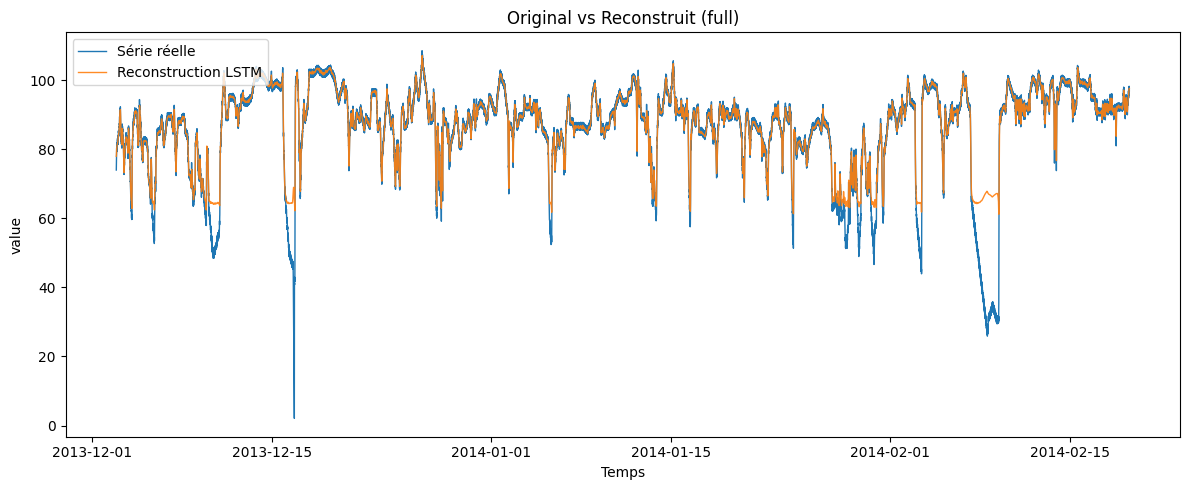

In [ ]:
# ===============================
# Reconstruction
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_reconstruction_mt(start=None, end=None, title_suffix="(full)"):
    ts        = df[TIME_COL]
    orig_val  = df[VALUE_COL].to_numpy()
    recon_val = df["recon"].to_numpy()

    mask = np.ones(len(df), dtype=bool)
    if start is not None:
        mask &= (ts >= pd.to_datetime(start))
    if end is not None:
        mask &= (ts <= pd.to_datetime(end))

    plt.figure(figsize=(12,5))
    plt.plot(ts[mask], orig_val[mask],  lw=1, label="Série réelle")
    plt.plot(ts[mask], recon_val[mask], lw=1, alpha=0.9, label="Reconstruction LSTM")
    plt.title(f"Original vs Reconstruit {title_suffix}")
    plt.xlabel("Temps")
    plt.ylabel(VALUE_COL)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


plot_reconstruction_mt()

In [ ]:
# =========================
# Seuils
# =========================
import numpy as np
import pandas as pd

# 1) Seuils calculés sur les points normaux uniquement
valid_mask = df["err_smooth"].notna().values
normal_mask_points = (df["label"].values == 0) & valid_mask
norm_err = df.loc[normal_mask_points, "err_smooth"].values

Q_HIGH, Q_LOW = 0.9941, 0.80
seuil_haut = np.quantile(norm_err, Q_HIGH)
seuil_bas  = np.quantile(norm_err, Q_LOW)
print(f"Seuils (calculés sur le normal) -> haut={seuil_haut:.4f} (Q{int(Q_HIGH*100)}), "
      f"bas={seuil_bas:.4f} (Q{int(Q_LOW*100)})")

# 2) Hystérèse avec PERSISTANCE
L_up, L_down = 2, 3

err   = df["err_smooth"].to_numpy()
flags = np.zeros(len(err), dtype=bool)
state = False
up_cnt = down_cnt = 0

for i, e in enumerate(err):
    if not np.isfinite(e):
        flags[i] = state
        continue
    if not state:
        if e > seuil_haut:
            up_cnt += 1
            if up_cnt >= L_up:
                state = True
                down_cnt = 0
        else:
            up_cnt = 0
    else:
        if e < seuil_bas:
            down_cnt += 1
            if down_cnt >= L_down:
                state = False
                up_cnt = 0
        else:
            down_cnt = 0
    flags[i] = state

y_true = (df["label"].values == 1) & valid_mask
y_pred = flags & valid_mask

TP = int(np.sum(y_pred & y_true))
FP = int(np.sum(y_pred & ~y_true))
FN = int(np.sum(~y_pred & y_true))
TN = int(np.sum(~y_pred & ~y_true))
n_true = int(np.sum(y_true))
n_pred = int(np.sum(y_pred))
n_total = int(np.sum(valid_mask))

precision = TP / (TP + FP) if (TP+FP) else 0.0
recall    = TP / (TP + FN) if (TP+FN) else 0.0
f1        = 2*precision*recall / (precision+recall) if (precision+recall) else 0.0

print("\n Comptes point-par-point :")
print(f"- Points valides                : {n_total}")
print(f"- VRAIS points anormaux (NAB)   : {n_true}")
print(f"- Points détectés par le LSTM   : {n_pred}")
print(f"   ↳ Vrais positifs (TP)        : {TP}")
print(f"   ↳ Faux positifs (FP)         : {FP}")
print(f"   ↳ Faux négatifs (FN)         : {FN}")
print(f"   ↳ Vrais négatifs (TN)        : {TN}")
print(f"\nMetrics : Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

# 4) Extraire les DATES des points détectés (aperçu + export CSV)
detected_points = df.loc[y_pred, [TIME_COL, VALUE_COL, "recon", "abs_err", "err_smooth"]].rename(
    columns={TIME_COL: "timestamp", VALUE_COL: "value"}
)
print("\n Aperçu des points détectés (les 15 premiers) :")
display(detected_points.head(15))

out_path = "detected_points_machine_temperature.csv"
detected_points.to_csv(out_path, index=False)
print(f"\n Exporté : {out_path}  (timestamps + valeurs + erreurs)")

Seuils (calculés sur le normal) -> haut=10.9200 (Q99), bas=0.6922 (Q80)

📊 Comptes point-par-point :
- Points valides                : 22672
- VRAIS points anormaux (NAB)   : 2268
- Points détectés par le LSTM   : 1306
   ↳ Vrais positifs (TP)        : 1031
   ↳ Faux positifs (FP)         : 275
   ↳ Faux négatifs (FN)         : 1237
   ↳ Vrais négatifs (TN)        : 20152

Metrics : Precision=0.789 | Recall=0.455 | F1=0.577

🕒 Aperçu des points détectés (les 15 premiers) :


,timestamp,value,recon,abs_err,err_smooth
2139,2013-12-10 07:30:00,52.546101,64.525826,11.979724,11.361757
2140,2013-12-10 07:35:00,53.219268,64.510707,11.291438,11.642493
2141,2013-12-10 07:40:00,52.449920,64.486563,12.036643,11.888205
2142,2013-12-10 07:45:00,53.122675,64.457074,11.334399,12.063849
2143,2013-12-10 07:50:00,51.768347,64.427420,12.659073,12.233356
2144,2013-12-10 07:55:00,51.950831,64.399603,12.448772,12.364133
2145,2013-12-10 08:00:00,51.854042,64.374989,12.520947,12.491837
2146,2013-12-10 08:05:00,51.425904,64.353344,12.927440,12.619094
2147,2013-12-10 08:10:00,51.459922,64.333578,12.873655,12.733240
2148,2013-12-10 08:15:00,52.506967,64.316947,11.809980,12.837075



💾 Exporté : detected_points_machine_temperature.csv  (timestamps + valeurs + erreurs)


In [ ]:
import requests, pandas as pd

def load_anomaly_windows_for(series_relpath: str):
    """
    Retourne [(start_ts, end_ts), ...] pour une série NAB donnée,
    en gérant les items au format dict {"start","end"} OU liste ["start","end"].
    """
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    windows = requests.get(labels_url).json()
    raw_list = windows.get(series_relpath, [])
    out = []
    for w in raw_list:
        if isinstance(w, dict) and "start" in w and "end" in w:
            s = pd.to_datetime(w["start"]); e = pd.to_datetime(w["end"])
        elif isinstance(w, (list, tuple)) and len(w) >= 2:
            s = pd.to_datetime(w[0]); e = pd.to_datetime(w[1])
        else:
            continue
        if e < s:
            s, e = e, s
        out.append((s, e))
    return out

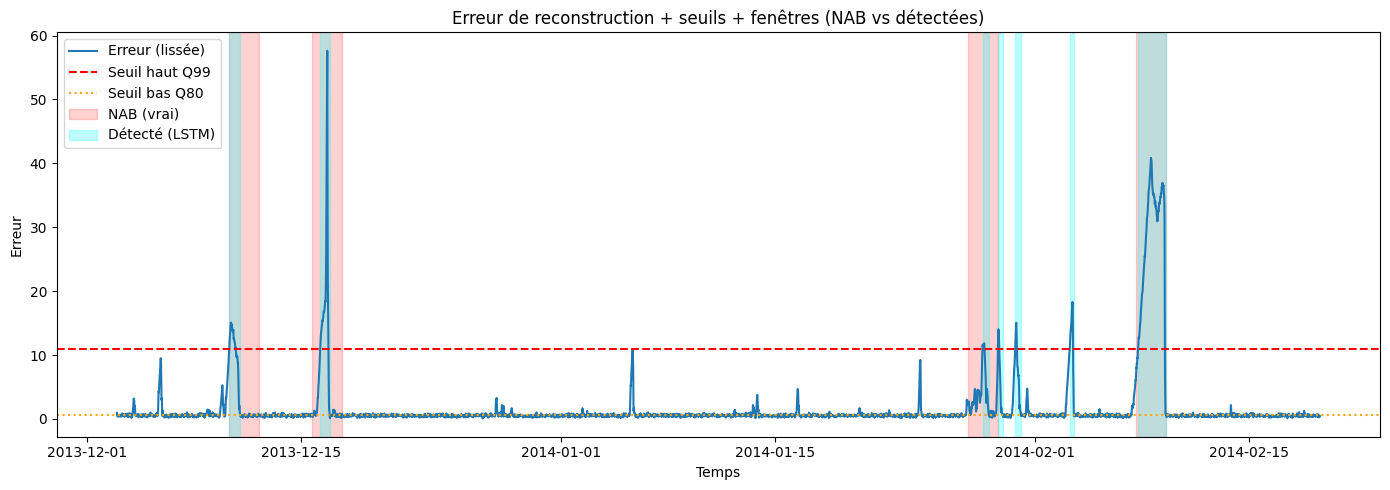

Fenêtres NAB : [(Timestamp('2013-12-10 06:25:00'), Timestamp('2013-12-12 05:35:00')), (Timestamp('2013-12-15 17:50:00'), Timestamp('2013-12-17 17:00:00')), (Timestamp('2014-01-27 14:20:00'), Timestamp('2014-01-29 13:30:00')), (Timestamp('2014-02-07 14:55:00'), Timestamp('2014-02-09 14:05:00'))]
Fenêtres détectées : [(Timestamp('2013-12-10 07:30:00'), Timestamp('2013-12-11 00:40:00')), (Timestamp('2013-12-16 06:25:00'), Timestamp('2013-12-16 21:05:00')), (Timestamp('2014-01-28 13:50:00'), Timestamp('2014-01-28 23:50:00')), (Timestamp('2014-01-29 14:05:00'), Timestamp('2014-01-29 21:35:00')), (Timestamp('2014-01-30 17:15:00'), Timestamp('2014-01-31 02:05:00'))] ... (total 7 )


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# reconstruit les intervalles à partir des flags booléens
def flags_to_intervals(flags, dates):
    ints = []
    on = False
    start = None
    for i in range(1, len(flags)):
        if flags[i] and not flags[i-1]:
            on = True; start = dates.iloc[i]
        if not flags[i] and flags[i-1]:
            on = False; ints.append((start, dates.iloc[i]))
    if on:
        ints.append((start, dates.iloc[-1]))
    return ints

detected_ints = flags_to_intervals(flags, df[TIME_COL])
true_ints = load_anomaly_windows_for("realKnownCause/machine_temperature_system_failure.csv")

plt.figure(figsize=(14,5))
plt.plot(df[TIME_COL], df["err_smooth"], lw=1.5, label="Erreur (lissée)")
plt.axhline(seuil_haut, color="r", ls="--", label=f"Seuil haut Q{int(Q_HIGH*100)}")
plt.axhline(seuil_bas,  color="orange", ls=":", label=f"Seuil bas Q{int(Q_LOW*100)}")


lab_done = False
for s,e in true_ints:
    plt.axvspan(s, e, color="red", alpha=0.18, label=None if lab_done else "NAB (vrai)")
    lab_done = True


lab_done = False
for s,e in detected_ints:
    plt.axvspan(s, e, color="cyan", alpha=0.25, label=None if lab_done else "Détecté (LSTM)")
    lab_done = True

plt.title("Erreur de reconstruction + seuils + fenêtres (NAB vs détectées)")
plt.xlabel("Temps"); plt.ylabel("Erreur")
plt.legend(loc="upper left")
plt.tight_layout(); plt.show()

print("Fenêtres NAB :", true_ints)
print("Fenêtres détectées :", detected_ints[:5], "... (total", len(detected_ints), ")")